## Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do mch of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

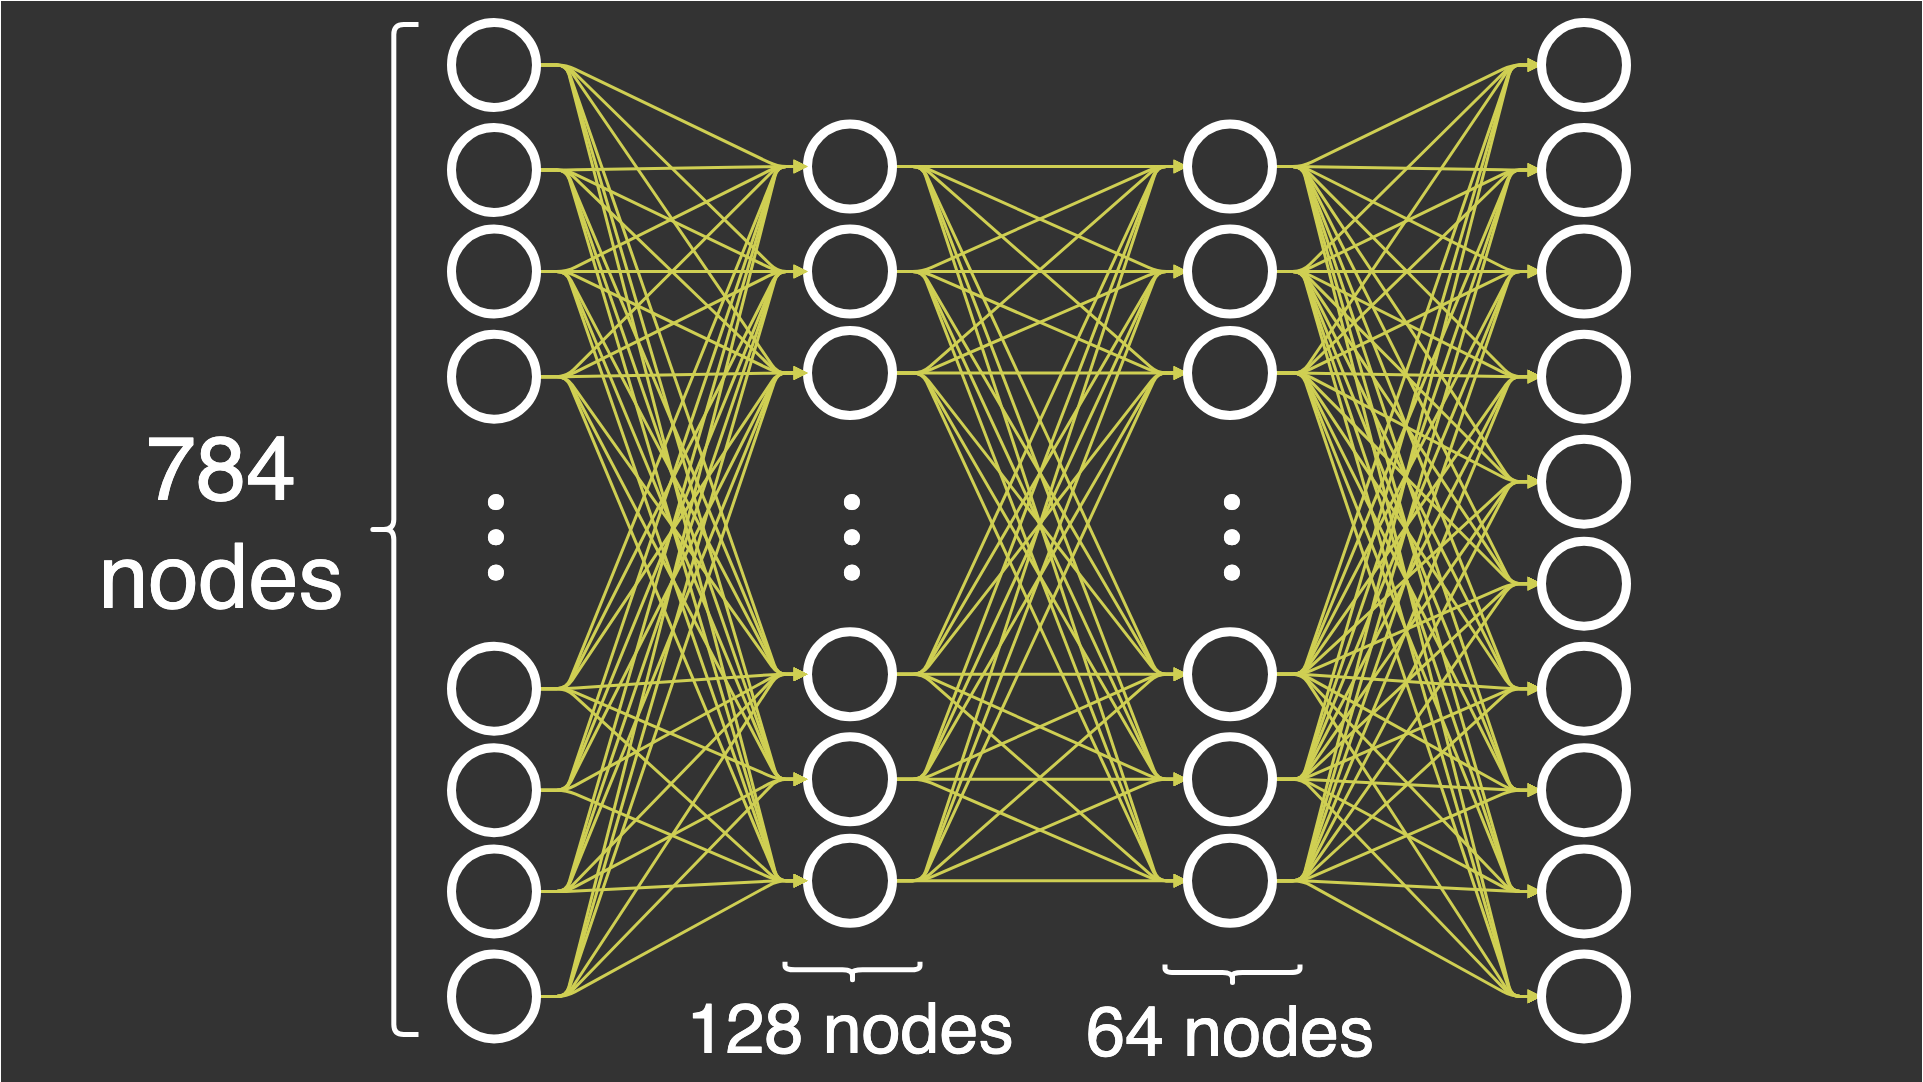

## Dataset

For this walkthrough, we will focus on importing the MNIST dataset and using that as the input to our deep neural networks. Note that this is purely a demonstration of how to make a neural network from scratch, and it is NOT the recommended architecture for solving the MNIST problem. We will reuse some code from one of the other articles on [Activation Functions Explained](https://mlfromscratch.com/activation-functions-explained/).

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Reshape to (n, 784)
x_train = x_train.reshape(-1, 784).astype('float32') / 255.
x_val = x_val.reshape(-1, 784).astype('float32') / 255.

# One-hot encode
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Create a single y (optional)
y = np.concatenate([y_train, y_val], axis=0)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(y.shape)   # combined y



(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)
(70000, 10)


In [ ]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
print(y[3])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## 4-layer Neural Network with NumPy

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(params['Z3'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    # def compute_accuracy(self, x_val, y_val):
    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         pred = np.argmax(output)
    #         predictions.append(pred == np.argmax(y))

    #     return np.mean(predictions)

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

create a function for sigmoid


In [ ]:
import numpy as np

def sigmoid(z):
    """Sigmoid activation"""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(activated_value):
    """Derivative of Sigmoid function"""
    return activated_value * (1 - activated_value)

Example for sigmoid


In [ ]:
print("Sigmoid:", sigmoid(np.array([0, 1, -1])))


Sigmoid: [0.5        0.73105858 0.26894142]


create a function for softmax


In [ ]:
def softmax(z):
    """Softmax activation for multi-class classification"""
    exp = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)


example for softmax


In [ ]:
print("Softmax:", softmax(np.array([[1, 2, 3]])))


Softmax: [[0.09003057 0.24472847 0.66524096]]


create a function for Binary Cross Entropy Loss

In [ ]:
def binary_cross_entropy(y_true, y_pred):
    """Binary Cross Entropy Loss"""
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))


example for Binary Cross Entropy Loss

In [ ]:
y_true = np.array([[1], [0], [1]])
y_pred = np.array([[0.9], [0.2], [0.8]])

print("Binary Cross Entropy:", binary_cross_entropy(y_true, y_pred))


Binary Cross Entropy: 0.18388253942874858


create a function for Parameter Initialization


In [ ]:
def initialize_parameters(layer_sizes):
    """
    layer_sizes = [input_dim, hidden1, hidden2, ..., output_dim]
    Returns dictionary of weights and biases
    """
    params = {}
    np.random.seed(42)

    for i in range(1, len(layer_sizes)):
        params[f"W{i}"] = np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2 / layer_sizes[i-1])
        params[f"b{i}"] = np.zeros((1, layer_sizes[i]))

    return params

example for paramater intialization


In [ ]:
params = initialize_parameters([2, 3, 1])
print("Initialized Parameters:", params.keys())


Initialized Parameters: dict_keys(['W1', 'b1', 'W2', 'b2'])


create a function for Forward Pass Function

In [ ]:
def forward_pass(X, params):
    """
    Returns activations A and pre-activations Z
    """
    A = {"A0": X}
    Z = {}
    L = len(params) // 2

    for i in range(1, L):
        Z[i] = A[f"A{i-1}"] @ params[f"W{i}"] + params[f"b{i}"]
        A[i] = sigmoid(Z[i])

    Z[L] = A[f"A{L-1}"] @ params[f"W{L}"] + params[f"b{L}"]
    A[L] = sigmoid(Z[L])  # for binary classification

    return A, Z


example for forward pass

create a function for Backward Pass Function

In [ ]:
def backward_pass(X, y, params, A, Z, learning_rate=0.01):
    grads = {}
    m = X.shape[0]
    L = len(params) // 2

    # Derivative of BCE loss w.r.t A[L]
    dA = -(y / A[L] - (1 - y) / (1 - A[L]))
    dZ = dA * sigmoid_derivative(A[L])

    grads[f"dW{L}"] = (A[f"A{L-1}"].T @ dZ) / m
    grads[f"db{L}"] = np.sum(dZ, axis=0, keepdims=True) / m

    # Hidden layers
    for i in range(L-1, 0, -1):
        dA = dZ @ params[f"W{i+1}"].T
        dZ = dA * sigmoid_derivative(A[i])
        grads[f"dW{i}"] = (A[f"A{i-1}"].T @ dZ) / m
        grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True) / m

    # Update weights
    for i in range(1, L+1):
        params[f"W{i}"] -= learning_rate * grads[f"dW{i}"]
        params[f"b{i}"] -= learning_rate * grads[f"db{i}"]

    return params


example for Backward Pass Function


In [ ]:
import numpy as np

# ----- Define activation and derivative functions globally for this example -----
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(activated_value):
    return activated_value * (1 - activated_value)


# ----- Corrected forward_pass function -----
def forward_pass(X, params):
    """
    Returns activations A and pre-activations Z
    """
    A = {"A0": X}  # Input layer activation, key "A0" is a string
    Z = {}
    L = len(params) // 2  # Number of layers with weights (e.g., 2 for [2,3,1] -> W1, b1, W2, b2)

    # Iterate for each layer that has weights (from 1 to L)
    for i in range(1, L + 1):
        # Calculate pre-activation Z for current layer i
        Z[f"Z{i}"] = A[f"A{i-1}"] @ params[f"W{i}"] + params[f"b{i}"]
        # Calculate activation A for current layer i
        A[f"A{i}"] = sigmoid(Z[f"Z{i}"])

    return A, Z

# ----- Corrected backward_pass function -----
def backward_pass(X, y, params, A, Z, learning_rate=0.01):
    grads = {}
    m = X.shape[0]
    L = len(params) // 2

    # Output layer
    # Derivative of BCE loss w.r.t logits (Z[L]) is simplified to A[L] - y
    dZ_L = A[f"A{L}"] - y

    grads[f"dW{L}"] = (A[f"A{L-1}"].T @ dZ_L) / m
    grads[f"db{L}"] = np.sum(dZ_L, axis=0, keepdims=True) / m

    # Hidden layers (iterate backwards)
    for i in range(L - 1, 0, -1):
        # dA for the previous layer's activation
        dA_prev = dZ_L @ params[f"W{i+1}"].T
        # dZ for the current hidden layer, using sigmoid_derivative on its activation
        dZ_prev = dA_prev * sigmoid_derivative(A[f"A{i}"])

        grads[f"dW{i}"] = (A[f"A{i-1}"].T @ dZ_prev) / m
        grads[f"db{i}"] = np.sum(dZ_prev, axis=0, keepdims=True) / m
        dZ_L = dZ_prev  # Update dZ_L for the next iteration (previous layer)

    # Update parameters (this part is actually for updating, not just calculating grads)
    for i in range(1, L + 1):
        params[f"W{i}"] -= learning_rate * grads[f"dW{i}"]
        params[f"b{i}"] -= learning_rate * grads[f"db{i}"]

    return params

# ----- Backward Pass Example -----

# Input sample
X = np.array([[0.5, 0.2]])

# True label (binary classification)
y = np.array([[1]])

# Initialize parameters
params = initialize_parameters([2, 3, 1])

# First run forward pass
A, Z = forward_pass(X, params)

# Run backward pass (update parameters)
params = backward_pass(X, y, params, A, Z, learning_rate=0.01)

# Print updated first layer weights
print("Updated W1 after backward pass:\n", params["W1"])

Updated W1 after backward pass:
 [[ 0.49714749 -0.13803796  0.64755224]
 [ 1.52320319 -0.23406284 -0.23419147]]


create a function for  Matplotlib Plot Function


In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(losses, accuracies):
    plt.figure(figsize=(12,4))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(losses)
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(accuracies)
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()


In [ ]:
!pip install transformers torch --quiet

In [ ]:
from transformers import pipeline

# Load an open-source transformer QA model
qa_model = pipeline("question-answering",
                    model="distilbert-base-cased-distilled-squad")

# Provide your paragraph here
context = """
Machine learning is a field of artificial intelligence that uses statistical techniques
to give computer systems the ability to learn from data. It focuses on developing
algorithms that improve automatically through experience. Popular ML methods include
supervised learning, unsupervised learning, and reinforcement learning.
"""

# Ask any question based on the paragraph
question = "What are popular machine learning methods?"

result = qa_model(question=question, context=context)

print("Question:", question)
print("Answer:", result['answer'])
print("Score:", result['score'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


Question: What are popular machine learning methods?
Answer: supervised learning, unsupervised learning, and reinforcement learning
Score: 0.7955707311630249


In [ ]:
from transformers import pipeline

# Load a different open-source QA model
qa_model = pipeline(
    "question-answering",
    model="deepset/roberta-base-squad2"
)

# New context paragraph
context = """
Cloud computing provides on-demand access to computing resources such as
servers, storage, databases, networking, and software over the internet.
It offers three major service models: Infrastructure as a Service (IaaS),
Platform as a Service (PaaS), and Software as a Service (SaaS).
Cloud platforms help organizations reduce costs, scale efficiently,
and improve reliability.
"""

# New question based on the context
question = "What are the major service models of cloud computing?"

# Running the QA model
result = qa_model(question=question, context=context)

# Output
print("Question:", question)
print("Answer:", result['answer'])
print("Score:", result['score'])


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

example for matplotlib function

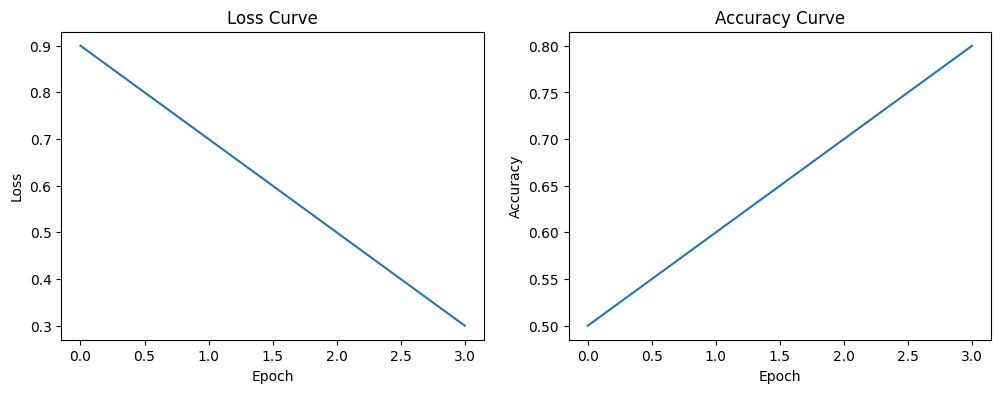

In [ ]:
losses = [0.9, 0.7, 0.5, 0.3]
accuracies = [0.5, 0.6, 0.7, 0.8]

plot_learning_curve(losses, accuracies)


Epoch: 1, Time Spent: 20.13s, Accuracy: 55.57%
Epoch: 1, Time Spent: 20.13s, Accuracy: 56.06%
Epoch: 1, Time Spent: 20.13s, loss: 0.33
Epoch: 1, Time Spent: 20.13s, loss: 0.14
-------------------------------------------------------------
Epoch: 2, Time Spent: 39.96s, Accuracy: 64.83%
Epoch: 2, Time Spent: 39.96s, Accuracy: 65.46%
Epoch: 2, Time Spent: 39.96s, loss: 0.29
Epoch: 2, Time Spent: 39.96s, loss: 0.10
-------------------------------------------------------------
Epoch: 3, Time Spent: 59.48s, Accuracy: 69.42%
Epoch: 3, Time Spent: 59.48s, Accuracy: 70.27%
Epoch: 3, Time Spent: 59.48s, loss: 0.26
Epoch: 3, Time Spent: 59.48s, loss: 0.07
-------------------------------------------------------------
Epoch: 4, Time Spent: 79.37s, Accuracy: 73.44%
Epoch: 4, Time Spent: 79.37s, Accuracy: 74.28%
Epoch: 4, Time Spent: 79.37s, loss: 0.21
Epoch: 4, Time Spent: 79.37s, loss: 0.04
-------------------------------------------------------------
Epoch: 5, Time Spent: 99.42s, Accuracy: 75.23%
E

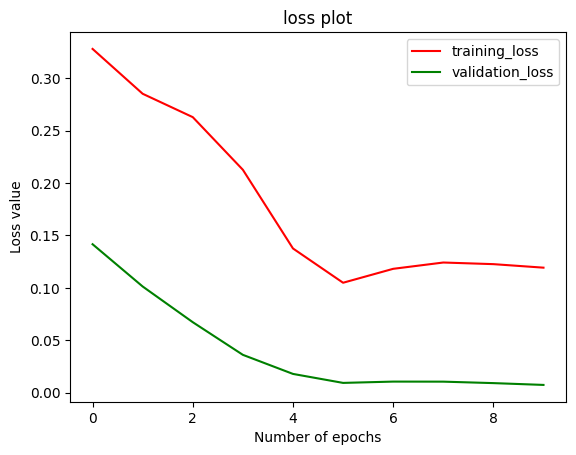

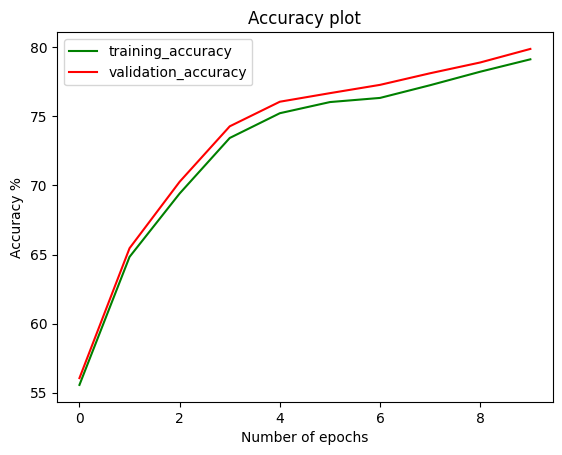

In [ ]:
dnn1 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.010)
dnn1.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 37.98s, Accuracy: 16.91%
Epoch: 1, Time Spent: 37.98s, Accuracy: 16.65%
Epoch: 1, Time Spent: 37.98s, loss: 0.30
Epoch: 1, Time Spent: 37.98s, loss: 0.30
-------------------------------------------------------------
Epoch: 2, Time Spent: 75.55s, Accuracy: 24.58%
Epoch: 2, Time Spent: 75.55s, Accuracy: 24.93%
Epoch: 2, Time Spent: 75.55s, loss: 0.31
Epoch: 2, Time Spent: 75.55s, loss: 0.31
-------------------------------------------------------------
Epoch: 3, Time Spent: 112.86s, Accuracy: 30.13%
Epoch: 3, Time Spent: 112.86s, Accuracy: 30.61%
Epoch: 3, Time Spent: 112.86s, loss: 0.31
Epoch: 3, Time Spent: 112.86s, loss: 0.32
-------------------------------------------------------------
Epoch: 4, Time Spent: 149.74s, Accuracy: 35.09%
Epoch: 4, Time Spent: 149.74s, Accuracy: 36.05%
Epoch: 4, Time Spent: 149.74s, loss: 0.32
Epoch: 4, Time Spent: 149.74s, loss: 0.31
-------------------------------------------------------------
Epoch: 5, Time Spent: 187.20s, Accuracy:

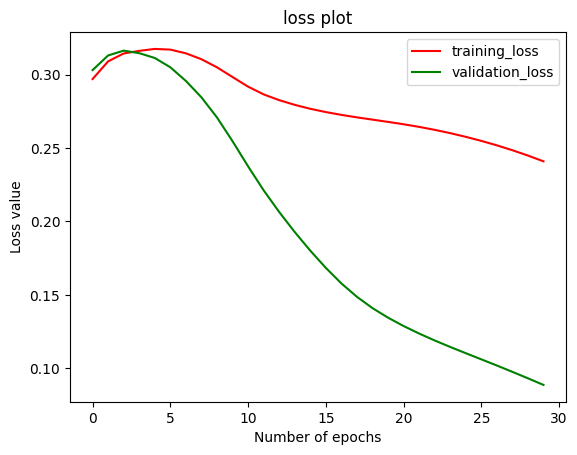

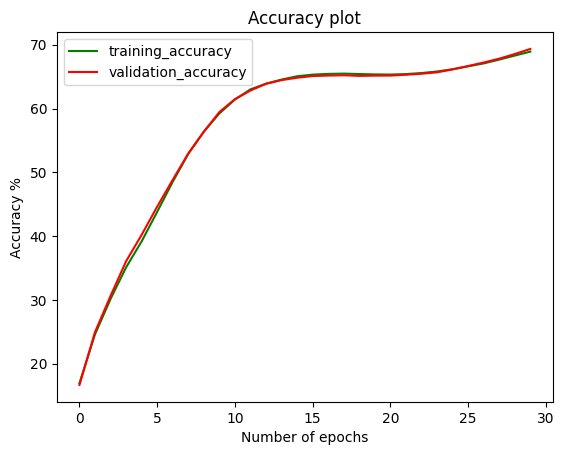

In [ ]:
dnn2 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=30, l_rate=0.001)
dnn2.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 38.19s, Accuracy: 38.49%
Epoch: 1, Time Spent: 38.19s, Accuracy: 39.33%
Epoch: 1, Time Spent: 38.19s, loss: 0.35
Epoch: 1, Time Spent: 38.19s, loss: 0.25
-------------------------------------------------------------
Epoch: 2, Time Spent: 75.67s, Accuracy: 46.05%
Epoch: 2, Time Spent: 75.67s, Accuracy: 46.41%
Epoch: 2, Time Spent: 75.67s, loss: 0.33
Epoch: 2, Time Spent: 75.67s, loss: 0.15
-------------------------------------------------------------
Epoch: 3, Time Spent: 113.43s, Accuracy: 54.02%
Epoch: 3, Time Spent: 113.43s, Accuracy: 54.87%
Epoch: 3, Time Spent: 113.43s, loss: 0.31
Epoch: 3, Time Spent: 113.43s, loss: 0.09
-------------------------------------------------------------
Epoch: 4, Time Spent: 151.44s, Accuracy: 61.65%
Epoch: 4, Time Spent: 151.44s, Accuracy: 62.28%
Epoch: 4, Time Spent: 151.44s, loss: 0.30
Epoch: 4, Time Spent: 151.44s, loss: 0.07
-------------------------------------------------------------
Epoch: 5, Time Spent: 188.97s, Accuracy:

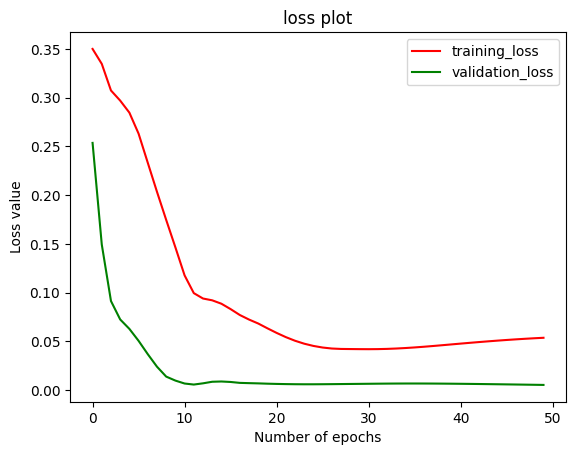

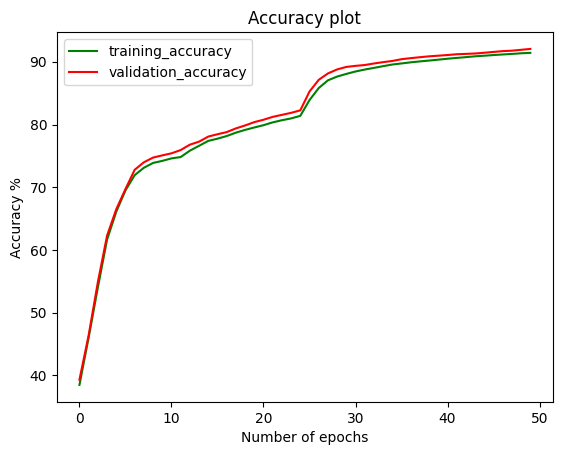

In [ ]:
dnn3 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.005)
dnn3.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 18.35s, Accuracy: 72.74%
Epoch: 1, Time Spent: 18.35s, Accuracy: 73.51%
Epoch: 1, Time Spent: 18.35s, loss: 0.20
Epoch: 1, Time Spent: 18.35s, loss: 0.06
-------------------------------------------------------------
Epoch: 2, Time Spent: 36.90s, Accuracy: 75.05%
Epoch: 2, Time Spent: 36.90s, Accuracy: 75.90%
Epoch: 2, Time Spent: 36.90s, loss: 0.09
Epoch: 2, Time Spent: 36.90s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 54.97s, Accuracy: 79.33%
Epoch: 3, Time Spent: 54.97s, Accuracy: 80.08%
Epoch: 3, Time Spent: 54.97s, loss: 0.04
Epoch: 3, Time Spent: 54.97s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 77.29s, Accuracy: 81.70%
Epoch: 4, Time Spent: 77.29s, Accuracy: 82.25%
Epoch: 4, Time Spent: 77.29s, loss: 0.04
Epoch: 4, Time Spent: 77.29s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 96.25s, Accuracy: 82.87%
E

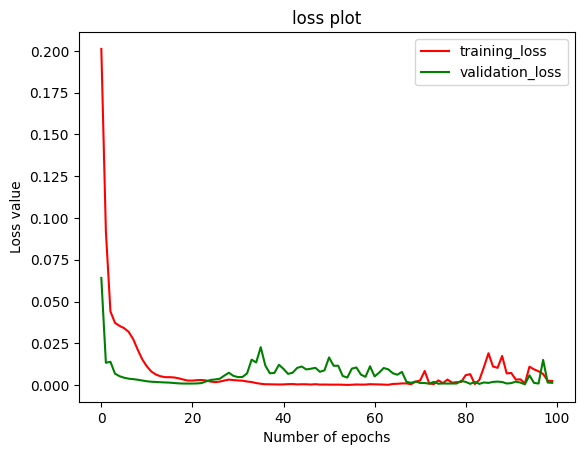

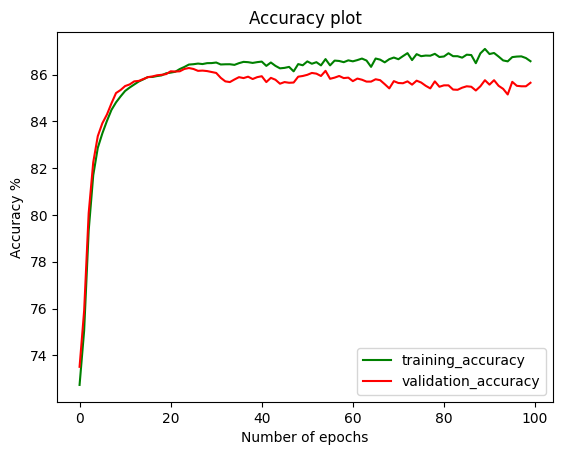

In [ ]:
dnn4 = DeepNeuralNetwork(sizes=[784, 64, 64, 10], epochs=100, l_rate=0.05)
dnn4.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 18.99s, Accuracy: 44.98%
Epoch: 1, Time Spent: 18.99s, Accuracy: 46.03%
Epoch: 1, Time Spent: 18.99s, loss: 0.34
Epoch: 1, Time Spent: 18.99s, loss: 0.30
-------------------------------------------------------------
Epoch: 2, Time Spent: 37.32s, Accuracy: 62.40%
Epoch: 2, Time Spent: 37.32s, Accuracy: 62.58%
Epoch: 2, Time Spent: 37.32s, loss: 0.32
Epoch: 2, Time Spent: 37.32s, loss: 0.16
-------------------------------------------------------------
Epoch: 3, Time Spent: 56.42s, Accuracy: 69.31%
Epoch: 3, Time Spent: 56.42s, Accuracy: 70.18%
Epoch: 3, Time Spent: 56.42s, loss: 0.30
Epoch: 3, Time Spent: 56.42s, loss: 0.10
-------------------------------------------------------------
Epoch: 4, Time Spent: 74.63s, Accuracy: 73.55%
Epoch: 4, Time Spent: 74.63s, Accuracy: 74.72%
Epoch: 4, Time Spent: 74.63s, loss: 0.26
Epoch: 4, Time Spent: 74.63s, loss: 0.07
-------------------------------------------------------------
Epoch: 5, Time Spent: 93.90s, Accuracy: 75.72%
E

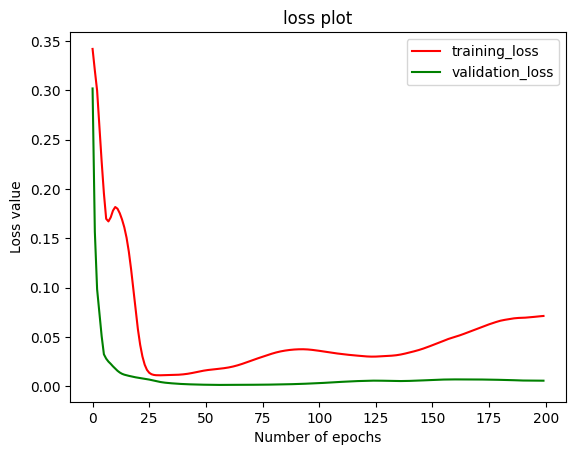

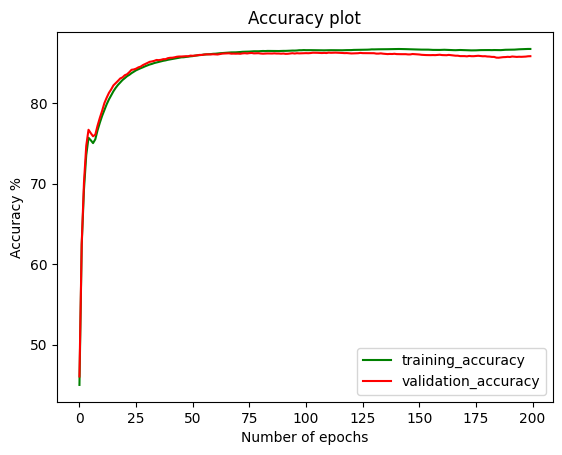

In [ ]:
dnn5 = DeepNeuralNetwork(sizes=[784, 64, 64, 10], epochs=200, l_rate=0.01)
dnn5.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 22.73s, Accuracy: 40.82%
Epoch: 1, Time Spent: 22.73s, Accuracy: 41.55%
Epoch: 1, Time Spent: 22.73s, loss: 0.36
Epoch: 1, Time Spent: 22.73s, loss: 0.31
-------------------------------------------------------------
Epoch: 2, Time Spent: 47.78s, Accuracy: 58.74%
Epoch: 2, Time Spent: 47.78s, Accuracy: 59.38%
Epoch: 2, Time Spent: 47.78s, loss: 0.35
Epoch: 2, Time Spent: 47.78s, loss: 0.22
-------------------------------------------------------------
Epoch: 3, Time Spent: 72.26s, Accuracy: 66.14%
Epoch: 3, Time Spent: 72.26s, Accuracy: 67.18%
Epoch: 3, Time Spent: 72.26s, loss: 0.29
Epoch: 3, Time Spent: 72.26s, loss: 0.17
-------------------------------------------------------------
Epoch: 4, Time Spent: 96.66s, Accuracy: 70.00%
Epoch: 4, Time Spent: 96.66s, Accuracy: 70.65%
Epoch: 4, Time Spent: 96.66s, loss: 0.27
Epoch: 4, Time Spent: 96.66s, loss: 0.12
-------------------------------------------------------------
Epoch: 5, Time Spent: 120.56s, Accuracy: 72.79%


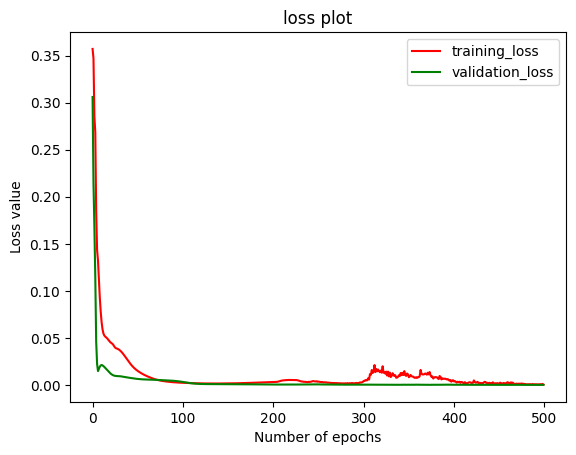

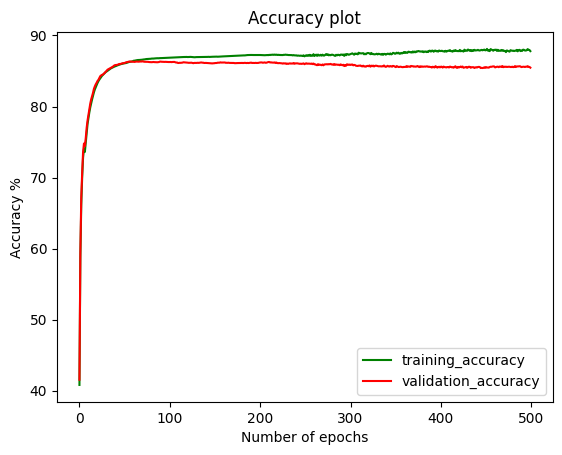

In [ ]:
dnn6 = DeepNeuralNetwork(sizes=[784, 64, 64, 10], epochs=500, l_rate=0.01)
dnn6.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 20.29s, Accuracy: 75.92%
Epoch: 1, Time Spent: 20.29s, Accuracy: 76.64%
Epoch: 1, Time Spent: 20.29s, loss: 0.13
Epoch: 1, Time Spent: 20.29s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 40.41s, Accuracy: 79.18%
Epoch: 2, Time Spent: 40.41s, Accuracy: 79.77%
Epoch: 2, Time Spent: 40.41s, loss: 0.08
Epoch: 2, Time Spent: 40.41s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 60.21s, Accuracy: 87.62%
Epoch: 3, Time Spent: 60.21s, Accuracy: 88.56%
Epoch: 3, Time Spent: 60.21s, loss: 0.06
Epoch: 3, Time Spent: 60.21s, loss: 0.02
-------------------------------------------------------------
Epoch: 4, Time Spent: 80.28s, Accuracy: 89.86%
Epoch: 4, Time Spent: 80.28s, Accuracy: 90.48%
Epoch: 4, Time Spent: 80.28s, loss: 0.04
Epoch: 4, Time Spent: 80.28s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 100.17s, Accuracy: 91.19%


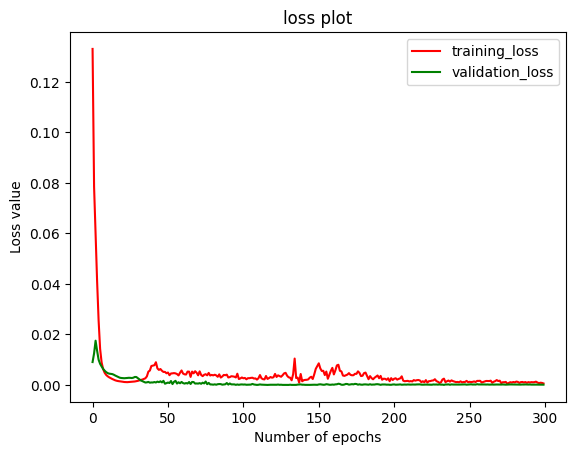

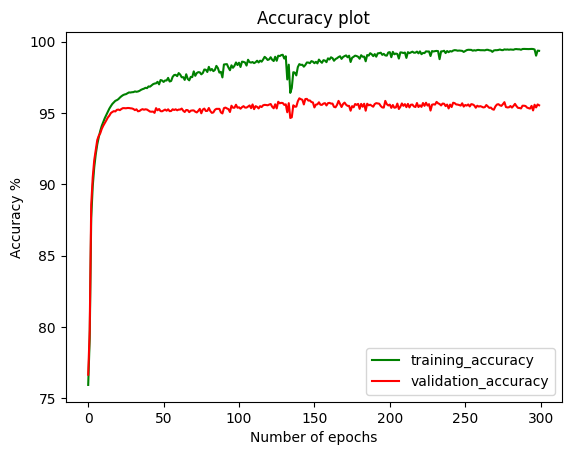

In [ ]:
dnn7 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=300, l_rate=0.05)
dnn7.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Step 1: Install Dependencies


In [ ]:
!pip install tensorflow opencv-python


Step 2: Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files


Step 3: Load MNIST Dataset


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test  = x_test  / 255.0


Step 4: Build and Train a Small DNN Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1, batch_size=32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8756 - loss: 0.4325


Step 5: Upload an Image for Prediction

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
    path = fn
    print("Uploaded:", path)


Saving handwritten Pixeljpeg.jpeg to handwritten Pixeljpeg.jpeg
Uploaded: handwritten Pixeljpeg.jpeg


Step 6: Preprocess + Predict

In [ ]:
def predict_digit(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Could not load image. Make sure it's an image file.")

    # Resize to 28×28
    img = cv2.resize(img, (28, 28))

    # Normalize
    img = img / 255.0

    # Invert if background is white
    if img.mean() > 0.5:
        img = 1 - img

    img = img.reshape(1, 28, 28)

    pred = model.predict(img)
    digit = np.argmax(pred)

    return digit, pred

digit, probs = predict_digit(path)
print("\nPredicted Digit:", digit)
print("Probabilities:\n", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step

Predicted Digit: 2
Probabilities:
 [[1.0786384e-06 5.2759262e-08 6.8127894e-01 2.7294922e-01 1.4457483e-12
  4.8639220e-03 3.7247684e-02 8.3249193e-07 3.6581072e-03 1.6022868e-07]]


In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
    path = fn
    print("Uploaded:", path)


Saving digital pixel.jpeg to digital pixel.jpeg
Uploaded: digital pixel.jpeg


In [ ]:
def predict_digit(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Could not load image. Make sure it's an image file.")

    # Resize to 28×28
    img = cv2.resize(img, (28, 28))

    # Normalize
    img = img / 255.0

    # Invert if background is white
    if img.mean() > 0.5:
        img = 1 - img

    img = img.reshape(1, 28, 28)

    pred = model.predict(img)
    digit = np.argmax(pred)

    return digit, pred

digit, probs = predict_digit(path)
print("\nPredicted Digit:", digit)
print("Probabilities:\n", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Predicted Digit: 3
Probabilities:
 [[2.5327280e-03 1.9995785e-05 5.4577786e-02 8.1275481e-01 7.3536080e-07
  1.2205706e-02 8.5377163e-04 3.5156894e-02 8.0058239e-02 1.8393175e-03]]


In [ ]:
#Ran in server and extracted results
SLN = {'Train_acc':[67.12,74.43,78.02,80.34,81.98,83.36,84.46,85.9,86.54,88.01],
       'Val_acc':[66.49,74.10,77.16,79.09,80.56,82.07,82.90,84.68,85.14,86.19]}

_SLN = {'Train_loss':[0.22,0.15,0.10,0.07,0.06,0.06,0.05,0.05,0.04,0.03],
       'Val_loss':[0.03,0.019,0.017,0.016,0.016,0.015,0.014,0.013,0.012,0.012]}


plt.figure(1)
plt.plot(np.array(dnn.tacc),'g',label='Conv_training_accuracy')
plt.plot(np.array(dnn.vacc),'o',label='Conv_validation_accuracy')
plt.plot(SLN['Train_acc'],'r',label='SLN_training_accuracy')
plt.plot(SLN['Val_acc'],'*',label='SLN_validation_accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy plot")
plt.legend()

plt.figure(2)
plt.plot(dnn.tls,'g',label='Conv_training_loss')
plt.plot(dnn.vls,'^',label='Conv_validation_loss')
plt.plot(_SLN['Train_loss'],'r',label='SLN_training_loss')
plt.plot(_SLN['Val_loss'],'*',label='SLN_validation_loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.title("loss plot")
plt.legend(loc='upper right',bbox_to_anchor=(1.0, 0.8))

## Seven layer network

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        hidden_3=self.sizes[3]
        hidden_4=self.sizes[4]
        hidden_5=self.sizes[5]
        hidden_6=self.sizes[6]
        output_layer=self.sizes[7]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(hidden_3, hidden_2) * np.sqrt(1. / hidden_3),
            'W4':np.random.randn(hidden_4, hidden_3) * np.sqrt(1. / hidden_4),
            'W5':np.random.randn(hidden_5, hidden_4) * np.sqrt(1. / hidden_5),
            'W6':np.random.randn(hidden_6, hidden_5) * np.sqrt(1. / hidden_6),
            'W7':np.random.randn(output_layer, hidden_6) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to hidden layer 3
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.sigmoid(params['Z3'])

        # hidden layer 3 to hidden layer 4
        params['Z4'] = np.dot(params["W4"], params['A3'])
        params['A4'] = self.sigmoid(params['Z4'])

        # hidden layer 4 to hidden layer 5
        params['Z5'] = np.dot(params["W5"], params['A4'])
        params['A5'] = self.sigmoid(params['Z5'])

        # hidden layer 5 to hidden layer 6
        params['Z6'] = np.dot(params["W6"], params['A5'])
        params['A6'] = self.sigmoid(params['Z6'])

        # hidden layer 6 to output layer (which is hidden layer 7 in the problem statement)
        params['Z7'] = np.dot(params["W7"], params['A6'])
        params['A7'] = self.softmax(params['Z7'])

        return params['A7']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        # Calculate W7 update (output layer)
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z7'], derivative=True)
        change_w['W7'] = np.outer(error, params['A6'])

        # Calculate W6 update
        error = np.dot(params['W7'].T, error) * self.sigmoid(params['Z6'], derivative=True)
        change_w['W6'] = np.outer(error, params['A5'])

        # Calculate W5 update
        error = np.dot(params['W6'].T, error) * self.sigmoid(params['Z5'], derivative=True)
        change_w['W5'] = np.outer(error, params['A4'])

        # Calculate W4 update
        error = np.dot(params['W5'].T, error) * self.sigmoid(params['Z4'], derivative=True)
        change_w['W4'] = np.outer(error, params['A3'])

        # Calculate W3 update
        error = np.dot(params['W4'].T, error) * self.sigmoid(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)


In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 128, 128, 64, 64, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

## CUPY in GPU

In [ ]:
!pip install cupy
import cupy as cp

In [ ]:
from sklearn.metrics import accuracy_score
import cupy as cp

class cDeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (cp.exp(-x))/((cp.exp(-x)+1)**2)
        return 1/(1 + cp.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = cp.exp(x - x.max())
        if derivative:
            return exps / cp.sum(exps, axis=0) * (1 - exps / cp.sum(exps, axis=0))
        return exps / cp.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':cp.asarray(np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1)),
            'W2':cp.asarray(np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2)),
            'W3':cp.asarray(np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer))
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = cp.dot(cp.asarray(params["W1"]), cp.asarray(params['A0']))
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(cp.asarray(params['Z1']))
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        #print("Axis dimension",np.shape(cp.asarray(params["W2"])))
        params['Z2'] = cp.dot(cp.asarray(params["W2"]), cp.asarray(params['A1']))
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(cp.asarray(params['Z2']))
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = cp.dot(cp.asarray(params["W3"]), cp.asarray(params['A2']))
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(cp.asarray(params['Z3']))
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0]  * self.softmax(cp.asarray(params['Z3']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W3'] = np.outer(error, params['A2'])
        change_w['W3'] = cp.tensordot(error[:, cp.newaxis], params['A2'][cp.newaxis, :], axes=0)

        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(cp.asarray(params['W3'].T), error) * self.sigmoid(cp.asarray(params['Z2']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W2'] = np.outer(error, params['A1'])
        change_w['W2'] = cp.tensordot(error[:, cp.newaxis], params['A1'][cp.newaxis, :], axes=0)
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(cp.asarray(params['W2'].T), error) * self.sigmoid(cp.asarray(params['Z1']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W1'] = np.outer(error, params['A0'])
        change_w['W1'] = cp.tensordot(error[:, cp.newaxis], cp.asarray(params['A0'])[cp.newaxis, :], axes=0)
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            #print("check type",key,type(self.params[key]))
            #print("check type v",type(value))
            #print("b_shape",key,np.shape(value),type(value))
            self.params[key] = self.params[key] - self.l_rate * np.squeeze(value)
            #print("shape",key,np.shape(self.params[key]))

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            res = pred == np.argmax(y)
            predictions.append(res)
            #print("predictions",predictions)
        return cp.mean(cp.asarray(predictions))

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            #print("----------------iteration {}------------".format(iteration))
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
                #print("-----------------count {}------------------".format(count))
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(cp.asarray(y), cp.asarray(output))
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)

            #accuracy = accuracy_score(out, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100 ))

In [ ]:
import numpy as np
dnn = cDeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
t = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(np.shape(t))
print(np.shape(cp.asarray(cp.asarray(t))))

In [ ]:
import random
np.shape(x_train)
UL = random.sample(range(1, 60000), 600)
_x_train = x_train[UL]
_y_train = y_train[UL]

UP = random.sample(range(1, 10000), 100)
_x_val = x_val[UP]
_y_val = y_val[UP]

import matplotlib.pyplot as plt
plt.imshow(_x_val[99])
print(_y_val[99])

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(_x_train.reshape(600,784), _y_train, _x_val.reshape(100,784), _y_val)

In [ ]:
import numpy as np
data = np.load('./mn_data.npy',allow_pickle=True)
_x_train = data.item()['x_train']
_y_train = data.item()['y_train']
_x_val = data.item()['x_val']
_y_val = data.item()['y_val']

In [ ]:
import time
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.001)
dnn.train(_x_train.reshape(6000,784)[:600], _y_train[:600], _x_val.reshape(500,784)[:50], _y_val[:50])

### Results

Completely dependent on how the weights are initialized, we get different results. Sometimes we are stuck at 0% accuracy, sometimes 5-10%, other times it jumps from 22% to 94.5%. If you want to experiment, try using a seed for numpy by `np.random.seed(42)` or any other number. Then you should get the same results each time.

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 120, 80, 10])
dnn.train(np.array(x_train), y_train, np.array(x_val), y_val)

## Gate Network

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class GateNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate


        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    import numpy as np

    def relu(self, x, derivative=False):
        if derivative:
            return(np.where(x > 0, 1, 0))  # Compute gradient of ReLU function
        return (np.maximum(0, x))

    def relu_old(self, x, derivative=False):
        if derivative:
          return (1 * (x>0))
        return (x * (x>0))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        np.random.seed(42)
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'E' :[],
            'FWC':[],
            'MWC':[],
            'LWC':[],
        }
        np.save('ini_weights',params)
        return params

    def forward_pass(self, x_train, iteration, logs=False):

        params = self.params
        km = 100
        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('W first layer', params['W1'])
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Z first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])


        # hidden layer 1 to hidden layer 2
        # print('W second layer', params['W2'])
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Z second layer', params['Z2'])
        params['A2'] = self.sigmoid(params['Z2'])


        # hidden layer 2 to output layer
        #print('W third layer', params['W3'])
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Z third layer', params['Z3'])
        params['A3'] = self.sigmoid(params['Z3'])
        print('Third layer activation', params['A3'])
        if logs == True and iteration % km == 0:
            print("---------------------First layer--------------------------")
            print('First layer Weights', params['W1'])
            print('First layer Activation', params['A1'])

            print("---------------------Second layer--------------------------")
            print('Second layer weights', params['W2'])
            print('Second layer activation', params['A2'])

            print("---------------------Third layer--------------------------")
            print('Third layer weights', params['W3'])
            print('Third layer activation', params['A3'])


        return params['A3']

    def backward_pass(self, y_train, output, iteration, count, logs=False):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}
        nm = 1
        # Calculate W3 update
        _error = self.binary_cross_entrophy(y_train, output, derivative=True)
        if(count == 1):
            self.params['E'].append(_error[0])
        error = _error * self.sigmoid(params['Z3'], derivative=True)
        #error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])
        if (count == -1):
            print("Error last layer", error)
            print("Change weight last layer", change_w['W3'])
            self.params['LWC'].append((np.sum(change_w['W3'])))
            print("--------------------------------------------")

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])
        if (count == -1):
            print("Error middle layer", error)
            print("Change weight middle layer ", change_w['W2'])
            self.params['MWC'].append(np.sum(np.sum(change_w['W2'])))
            print("--------------------------------------------")

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])
        if (count == -1):
            print("Error first layer", error)
            print("Change weight first layer", change_w['W1'])
            self.params['FWC'].append(np.sum(np.sum(change_w['W1'])))
            print("--------------------------------------------")
        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_loss(self, output, y_train):

        return((output - y_train)**2)

    def compute_accuracy(self, x_val, y_val):

        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x, 1, logs=False)
            #print("output",output)
            #pred = np.argmax(output)
            #predictions.append(pred == np.argmax(y))
            if output > 0.5:
               out = 1
            else:
               out = 0
            predictions.append(out)
        return predictions

    def train(self, x_train, y_train, x_val, y_val):
        #predictions = []
        start_time = time.time()
        self.ls=[]
        self.acc=[]
        for iteration in range(self.epochs):
            count=0
            print("---------------------Epoch {}--------------------------".format(iteration))
            for x, y in zip(x_train, y_train):
                count+=1
                print("---------------------Sample {}--------------------------".format(count))
                output = self.forward_pass(x, iteration, logs=False)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output, iteration, count, logs = False )
          #      print("-------------------------------Backprop")
                #for k,v in changes_to_w.items():
                #    print(k,v)
                #print("-----------Sample{}-------------".format(count))
                self.update_network_parameters(changes_to_w)
            #print("---------------------End of Epoch---------------------")
            loss = self.binary_cross_entrophy(y_train, output, derivative=False)
            #loss = self.compute_loss(output,y_train)
            out = self.compute_accuracy(x_val, y_val)
            #print("Predictions",out)
            #print("Loss",out)
            accuracy = accuracy_score(out, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100 ))
            self.ls.append(np.mean(loss))
            self.acc.append(accuracy)
        np.save('final_weights',self.params)
        plt.figure(1)
        plt.plot(self.ls)
        plt.title("loss")
        plt.figure(2)
        plt.plot(self.acc,'r')
        plt.title("Accuracy")
        # plt.figure(3)
        # plt.plot(self.params['FWC'],'g')
        # plt.title("Weight change over epochs First layer")
        # plt.figure(4)
        # plt.plot(self.params['MWC'],'y')
        # plt.title("Weight change over epochs middle layer")
        # plt.figure(5)
        # plt.plot(self.params['LWC'],'b')
        # plt.title("Weight change over epochs last layer")
        # plt.figure(6)
        # plt.plot(self.params['E'],'o')
        # plt.title("Error change over epochs last layer")


In [ ]:
#X_train = np.array([[0,0,0],[0,0,1],[0,1,1],[1,1,0],[1,0,1],[1,1,1],[0,1,0],[1,0,0]])
#Y_train = np.array([[0],[0],[1],[1],[1],[1],[0],[0]])
#X_val = X_train
#Y_val = Y_train
#print(np.shape(X_val))


# 16 Sample dataset
X_train = np.array([[1,1,1,1],[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]])
Y_train = np.array([[1],[0],[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[1],[1]])
X_val = X_train
Y_val = Y_train
#print(np.shape(X_val))
#X_val = np.array([[0,1,0,0],[1,1,1,0],[0,1,0,1]])
#Y_val = np.array([[0],[1],[0]])

#X_train = np.array([[0,0,0,1]])
#Y_train = np.array([[1]])
#X_val = X_train
#Y_val = Y_train

dnn = GateNeuralNetwork(sizes=[4, 4, 4, 1], epochs=4000, l_rate=0.001)
dnn.train(X_train, Y_train, X_val, Y_val)

In [ ]:
import matplotlib.pyplot as plt

ini_weights = np.load("ini_weights.npy", allow_pickle=True)
print(ini_weights.item())
print("---------------------------------------------------")
final_weights = np.load("final_weights.npy", allow_pickle=True)
print(final_weights.item())
print("---------------------------------------------------")
diff = final_weights.item()['W3'][0] - ini_weights.item()['W3'][0]
plt.title("Difference in weights of last layer")
plt.bar(np.array(["0n", "1n", "2n", "3n"]), diff)
plt.figure(2)
plt.plot(final_weights.item()['E'])

In [ ]:
plt.figure(2)
plt.plot(final_weights.item()['E'],'.')

In [ ]:
print("First minima iteration number and value", np.where(dnn.ls == min(dnn.ls)), min(dnn.ls))
print("Second minima iteration number and value", np.where(dnn.ls == np.sort(dnn.ls)[3]), np.sort(dnn.ls)[1])

In [ ]:
print("First minima iteration number and value", np.where(dnn.ls == min(dnn.ls)), min(dnn.ls))
print("Second minima iteration number and value", np.where(dnn.ls == np.sort(dnn.ls)[1]), np.sort(dnn.ls)[1])

## Loading MNIST with PyTorch

Importing with PyTorch is straight away more complicated than we saw previously. This was one of the things that threw me off at first, but it seems straight forward once you get what the DataLoader returns you, and how you can access the data in the objects.

In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform))

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transform))

## 4-layer Neural Network With PyTorch

In [ ]:
for x,y in train_loader:
  print(np.shape(torch.flatten(x)))
  print(np.shape(y))
  break

In [ ]:
import numpy as np
X_train = np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]],dtype=np.compat.long)
Y_train = np.array([[0],[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[1],[1]],dtype=np.compat.long)
X_val = X_train
Y_val = Y_train

In [ ]:
X_train.dtype

In [ ]:
import torch
xx = (torch.from_numpy(X_train).type(torch.LongTensor))
xx.dtype

In [ ]:
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, epochs=10):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(4, 4)
        self.linear2 = nn.Linear(4, 4)
        self.linear3 = nn.Linear(4, 1)

        self.epochs = epochs

    def forward_pass(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x

    def one_hot_encode(self, y):
        encoded = torch.zeros([1], dtype=torch.float64)
        encoded[y[0]] = 1.
        return encoded

    def train(self, X_train, Y_train, optimizer):
      #criterion
        start_time = time.time()
        loss = None

        for iteration in range(self.epochs):
            for x,y in zip(X_train, Y_train):
                #y = self.one_hot_encode(y)
                print((y))
                optimizer.zero_grad()
                output = self.forward_pass(torch.from_numpy(x).type(torch.LongTensor))
                loss = criterion(output, torch.from_numpy(y).type(torch.LongTensor))
                loss.backward()
                optimizer.step()

            print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(
                iteration+1, time.time() - start_time, loss
            ))

In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

model.train(X_train, Y_train, optimizer)

## TensorFlow 2.0 with Keras

Now that we know just how much code lies behind a simple neural network in NumPy and PyTorch, let's look at how easily we can construct the same network in TensorFlow (with Keras).

With TensorFlow and Keras, we don't have to think as much about activation functions, optimizers etc., since they are already implemented. On top of this, we will see huge improvements in the time it takes to execute and train a neural network, since the frameworks are completely optimized compared to NumPy.

The following approach goes for a complete Keras solution, without a custom training function or anything very TensorFlow related. Go to the end of my [TensorFlow 2.0 tutorial](https://mlfromscratch.com/tensorflow-2/#custom-train-and-test-functions-in-tensorflow-2-0) to see what a custom training function looks like.

In [ ]:
!pip install --upgrade tensorflow-gpu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
# Not using this code
#import numpy as np
#X_train = np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,1]])
#Y_train = np.array([[0],[0],[0],[0],[1],[0],[0],[1],[1],[1],[1],[1],[1]])
#X_val = np.array([[0,1,0,0],[1,1,1,0],[0,1,0,1]])
#Y_val = np.array([[0],[1],[0]])

In [ ]:
model = tf.keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

#history = model.fit(X_train.reshape(13,1,4), Y_train, validation_data=(X_val.reshape(3,1,4), Y_val), epochs=2000)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(history.history['loss'])
plt.title("Loss")
plt.figure(2)
plt.plot(history.history['accuracy'],'r')
plt.title("Acc",)
plt.figure(3)
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.figure(4)
plt.plot(history.history['val_accuracy'],'r')
plt.title("Acc",)

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
out = model.predict(X_train.reshape(16,1,4))

In [ ]:
from sklearn.metrics import accuracy_score
pred = np.multiply((out > 0.5),1)

Saving Screenshot 2025-11-30 181645.png to Screenshot 2025-11-30 181645.png


(np.float64(-0.5), np.float64(471.5), np.float64(316.5), np.float64(-0.5))

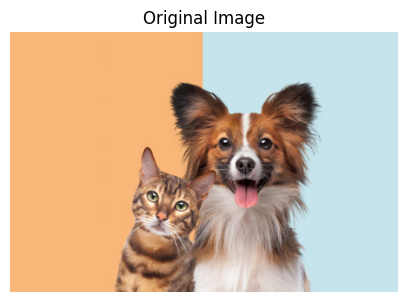

In [ ]:
# =============================
# 1. Import Required Libraries
# =============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# =============================
# 2. Upload Image
# =============================
uploaded = files.upload()

# Read uploaded file name
image_path = list(uploaded.keys())[0]

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")


Convert to Grayscale

(np.float64(-0.5), np.float64(471.5), np.float64(316.5), np.float64(-0.5))

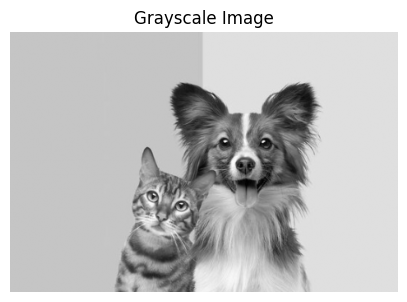

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(5,5))
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')
plt.axis("off")


Define Sobel Filters

In [ ]:
# Sobel X kernel
sobel_x = np.array([
                    [-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]
                   ])

# Sobel Y kernel
sobel_y = np.array([
                    [-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]
                   ])


In [ ]:
Manual Convolution Function

In [ ]:
def convolve(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape

    pad_h = kh // 2
    pad_w = kw // 2

    # Padding the image
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    output = np.zeros((h, w), dtype=np.float32)

    # Convolution Operation
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)

    return output


Apply Sobel Filters With Convolution

In [ ]:
# Sobel X
grad_x = convolve(gray, sobel_x)

# Sobel Y
grad_y = convolve(gray, sobel_y)

# Compute Gradient Magnitude
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_mag = (grad_mag / grad_mag.max()) * 255
grad_mag = grad_mag.astype(np.uint8)


Display Output Layers

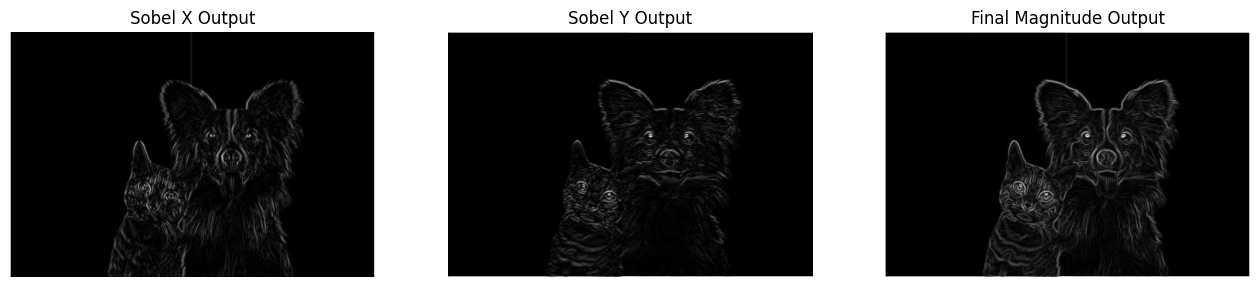

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.title("Sobel X Output")
plt.imshow(np.abs(grad_x), cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Sobel Y Output")
plt.imshow(np.abs(grad_y), cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Final Magnitude Output")
plt.imshow(grad_mag, cmap='gray')
plt.axis("off")

plt.show()
